In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from collections import defaultdict
from copy import deepcopy

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def alter_pathway(input_filename, output_filename, alterations):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(input_filename)
    model = document.getModel()

    for i in range(model.getNumParameters()):
        param = model.getParameter(i)
        if param.getId() == alterations:
            previous_value = param.getValue()
            param.setValue(previous_value * 100)
            modified_sbml = libsbml.writeSBML(document, output_filename)
            return 

In [4]:
def generate_test_set(filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    for i in range(model.getNumParameters()):
        base_dir = 'altered_pathways2'
        alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
        file_dir = os.path.join(alteration_dir, 'reaction_' + str(i) + '100x.xml')
        os.makedirs(alteration_dir, exist_ok=True)
        
        param = model.getParameter(i)

        alter_pathway(filename, file_dir, param.getId())

In [5]:
generate_test_set('BIOMD0000000030.xml')

In [6]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) >= 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [7]:
convert_sbml_to_network('BIOMD0000000030.xml')

number reactions 20
number species 18


In [8]:
for i in range(len(description['reactions'])):
    desc = deepcopy(description)
    desc['altered'] = desc['reactions'][i][0]
    base_dir = 'altered_pathways2'
    alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
    description_path = os.path.join(alteration_dir, 'description')
    description_file = open(description_path, 'wb')
    pickle.dump(desc, description_file)
    description_file.close()
    

In [9]:
desc_path = 'altered_pathways2/reaction_22/description'
desc_file = open(desc_path, 'rb')
temp = pickle.load(desc_file)
desc_file.close()
temp

{'species': ['M',
  'MpY',
  'MpT',
  'Mpp',
  'MAPKK',
  'MKP',
  'MpY_MAPKK',
  'MpT_MAPKK',
  'M_MAPKK_Y',
  'M_MAPKK_T',
  'Mpp_MKP_Y',
  'Mpp_MKP_T',
  'MpY_MKP_Y',
  'MpY_MKP_T',
  'MpT_MKP_Y',
  'MpT_MKP_T',
  'M_MKP_T',
  'M_MKP_Y'],
 'reactions': [['reaction_0000001', 0, 1],
  ['reaction_0000001revert', 0, 1],
  ['reaction_0000002', 0, 1],
  ['reaction_0000003', 0, 1],
  ['reaction_0000003revert', 0, 1],
  ['reaction_0000004', 0, 1],
  ['reaction_0000005', 0, 1],
  ['reaction_0000005revert', 0, 1],
  ['reaction_0000006', 0, 1],
  ['reaction_0000007', 0, 1],
  ['reaction_0000007revert', 0, 1],
  ['reaction_0000008', 0, 1],
  ['reaction_0000009', 0, 1],
  ['reaction_0000009revert', 0, 1],
  ['reaction_0000010', 0, 1],
  ['reaction_0000011', 0, 1],
  ['reaction_0000011revert', 0, 1],
  ['reaction_0000013', 0, 1],
  ['reaction_0000013revert', 0, 1],
  ['reaction_0000012', 0, 1],
  ['reaction_0000015', 0, 1],
  ['reaction_0000015revert', 0, 1],
  ['reaction_0000017', 0, 1],
  ['rea

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000030.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 3186.0
Converged at time 3254.0
Specie:  M expected result:  increased  normal final:  0.11152886445834718  altered final:  0.22611459977880874
confidence interval:  [0.6336620260722535, 0.644235770222299]
deltas coming from simulation:  [0.11458573532046155, 0]
Specie:  MpY expected result:  increased  normal final:  0.7727277129180722  altered final:  0.7750308836595244
confidence interval:  [0.3426453400492216, 0.35290445338355947]
deltas coming from simulation:  [0.002303170741452254, 0]
Specie:  MpT expected result:  increased  normal final:  0.7726970685956135  altered final:  0.7764975591607896
confidence interval:  [0.5118905363148641, 0.514381151868268]
deltas coming from simulation:  [0.0038004905651760623, 0]
Specie:  Mpp expected result:  decreased  normal final:  698.5654965161328  altered final:  697.6427349732677
confidence interval:  [0.47728291898634584, 0.48238778958435435]
deltas coming from simulation:  [-0.9227615428651461, 0]
Specie:  MAPKK expec

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.6961805555555556


In [4]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 1710,
 'uncertain_species': 27,
 'correct_species': 1184,
 'true_positives': 566,
 'false_positives': 292,
 'false_negatives': 234,
 'true_negatives': 618}

In [4]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  576  correct:  401  uncertain:  10  true pos:  198  true neg:  203  false_pos:  90 false neg:  85


In [6]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [7]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [54]:
description

{'species': ['M',
  'MpY',
  'MpT',
  'Mpp',
  'MAPKK',
  'MKP',
  'MpY_MAPKK',
  'MpT_MAPKK',
  'M_MAPKK_Y',
  'M_MAPKK_T',
  'Mpp_MKP_Y',
  'Mpp_MKP_T',
  'MpY_MKP_Y',
  'MpY_MKP_T',
  'MpT_MKP_Y',
  'MpT_MKP_T',
  'M_MKP_T',
  'M_MKP_Y'],
 'reactions': [['reaction_0000001', 0, 1],
  ['reaction_0000001revert', 0, 1],
  ['reaction_0000002', 0, 1],
  ['reaction_0000003', 0, 1],
  ['reaction_0000003revert', 0, 1],
  ['reaction_0000004', 0, 1],
  ['reaction_0000005', 0, 1],
  ['reaction_0000005revert', 0, 1],
  ['reaction_0000006', 0, 1],
  ['reaction_0000007', 0, 1],
  ['reaction_0000007revert', 0, 1],
  ['reaction_0000008', 0, 1],
  ['reaction_0000009', 0, 1],
  ['reaction_0000009revert', 0, 1],
  ['reaction_0000010', 0, 1],
  ['reaction_0000011', 0, 1],
  ['reaction_0000011revert', 0, 1],
  ['reaction_0000013', 0, 1],
  ['reaction_0000013revert', 0, 1],
  ['reaction_0000012', 0, 1],
  ['reaction_0000015', 0, 1],
  ['reaction_0000015revert', 0, 1],
  ['reaction_0000017', 0, 1],
  ['rea

In [5]:
description['altered'] = 'reaction_0000001'
description

{'species': ['M',
  'MpY',
  'MpT',
  'Mpp',
  'MAPKK',
  'MKP',
  'MpY_MAPKK',
  'MpT_MAPKK',
  'M_MAPKK_Y',
  'M_MAPKK_T',
  'Mpp_MKP_Y',
  'Mpp_MKP_T',
  'MpY_MKP_Y',
  'MpY_MKP_T',
  'MpT_MKP_Y',
  'MpT_MKP_T',
  'M_MKP_T',
  'M_MKP_Y'],
 'reactions': [['reaction_0000001', 0, 1],
  ['reaction_0000001revert', 0, 1],
  ['reaction_0000002', 0, 1],
  ['reaction_0000003', 0, 1],
  ['reaction_0000003revert', 0, 1],
  ['reaction_0000004', 0, 1],
  ['reaction_0000005', 0, 1],
  ['reaction_0000005revert', 0, 1],
  ['reaction_0000006', 0, 1],
  ['reaction_0000007', 0, 1],
  ['reaction_0000007revert', 0, 1],
  ['reaction_0000008', 0, 1],
  ['reaction_0000009', 0, 1],
  ['reaction_0000009revert', 0, 1],
  ['reaction_0000010', 0, 1],
  ['reaction_0000011', 0, 1],
  ['reaction_0000011revert', 0, 1],
  ['reaction_0000013', 0, 1],
  ['reaction_0000013revert', 0, 1],
  ['reaction_0000012', 0, 1],
  ['reaction_0000015', 0, 1],
  ['reaction_0000015revert', 0, 1],
  ['reaction_0000017', 0, 1],
  ['rea

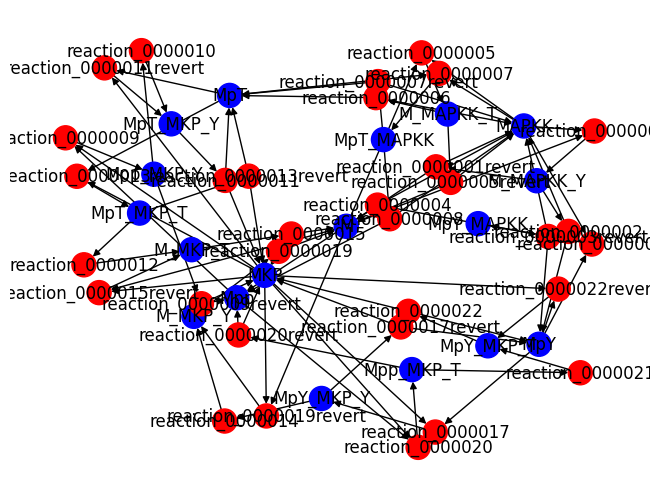

In [56]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [58]:
description_path = 'description_reaction_0000001_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

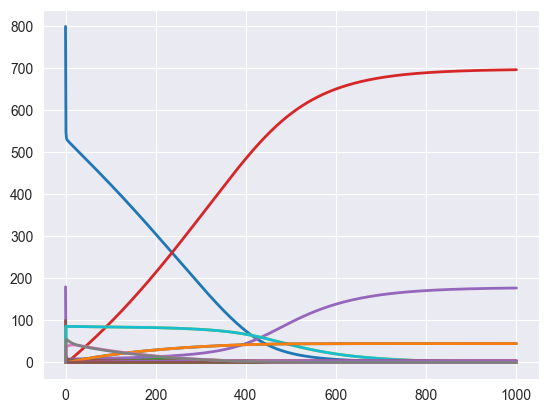

       time,      [M],    [MpY],    [MpT],     [Mpp], [MAPKK],   [MKP], [MpY_MAPKK], [MpT_MAPKK], [M_MAPKK_Y], [M_MAPKK_T], [Mpp_MKP_Y], [Mpp_MKP_T], [MpY_MKP_Y], [MpY_MKP_T], [MpT_MKP_Y], [MpT_MKP_T], [M_MKP_T], [M_MKP_Y]
 [[       0,      800,        0,        0,         0,     180,     100,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,         0,         0],
  [   1.001,  548.484, 0.605397, 0.605211, 0.0763163, 7.90289, 21.8676,  0.00895561,  0.00895314,     86.0396,     86.0396,    0.025875,    0.025875,   0.0641542,   0.0760983,   0.0760877,   0.0635108,   30.1424,   47.6584],
  [   2.002,  535.043,  1.17623,  1.17524,  0.366205, 8.10533,  9.6549,   0.0185111,    0.018496,     85.9288,     85.9288,   0.0833833,   0.0833833,    0.076762,    0.106607,    0.106556,   0.0754176,   35.6769,   54.1361],
  [   3.003,  531.428,  1.64657,  1.64462,  0.854946, 8.15998, 7.41403,   0.0264383,   0.0264075,     

In [6]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000030.xml')

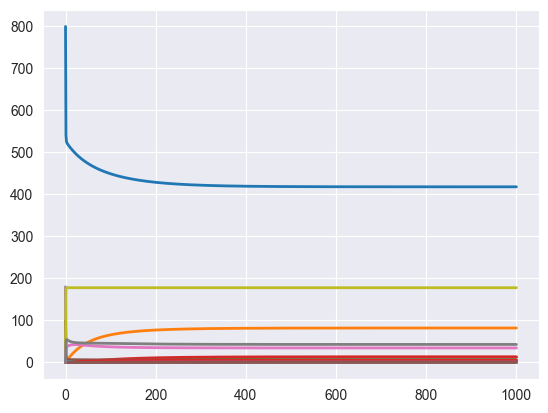

       time,     [M],   [MpY],     [MpT],      [Mpp],  [MAPKK],   [MKP], [MpY_MAPKK], [MpT_MAPKK], [M_MAPKK_Y], [M_MAPKK_T], [Mpp_MKP_Y], [Mpp_MKP_T], [MpY_MKP_Y], [MpY_MKP_T], [MpT_MKP_Y], [MpT_MKP_T], [M_MKP_T], [M_MKP_Y]
 [[       0,     800,       0,         0,          0,      180,     100,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,         0,         0],
  [   1.001, 541.246, 1.40697, 0.0140681, 0.00181605,  0.16612, 22.5024, 0.000435806, 4.35754e-06,     178.053,     1.78053, 0.000609065, 0.000609065,    0.153117,    0.180623,   0.0018204,  0.00151566,   29.8695,   47.2898],
  [   2.002, 527.103, 2.98069, 0.0298253, 0.00925389, 0.170579, 9.95247, 0.000981614, 9.82139e-06,     178.048,     1.78048,  0.00210782,  0.00210782,    0.191609,    0.255709,  0.00264496,   0.0018846,   35.5228,   54.0687],
  [   3.003, 523.151, 4.58358, 0.0459626,  0.0230507, 0.171867, 7.63207,  0.00154123, 1.54523e-05,

In [7]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000030_reaction1_100x.xml')

In [5]:
species = description['species']
species

['M',
 'MpY',
 'MpT',
 'Mpp',
 'MAPKK',
 'MKP',
 'MpY_MAPKK',
 'MpT_MAPKK',
 'M_MAPKK_Y',
 'M_MAPKK_T',
 'Mpp_MKP_Y',
 'Mpp_MKP_T',
 'MpY_MKP_Y',
 'MpY_MKP_T',
 'MpT_MKP_Y',
 'MpT_MKP_T',
 'M_MKP_T',
 'M_MKP_Y']

In [8]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [9]:
final_normal

[1.00000000e+03 3.00866351e-01 7.79705207e-01 7.79673983e-01
 6.97029452e+02 1.77322666e+02 1.56703191e+00 2.76519045e-01
 2.76507972e-01 1.06215360e+00 1.06215360e+00 4.50109718e+01
 4.50109718e+01 8.31226570e-03 4.15322404e+00 4.15322355e+00
 8.14568342e-03 5.38774283e-02 3.42415838e-02]

In [10]:
temp = final_concentrations_normal[1]
temp

[800.   0.   0.   0. 180. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]

In [15]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

M
final normal:  0.3008663511104781 final altered:  418.22085747052023 delta:  417.91999111940976 relative delta  1389.0552718072138 initial concentration:  800.0 delta1 0.5223999888992622 delta2 1389.0552718072138
MpY
final normal:  0.779705206632577 final altered:  82.08120701725106 delta:  81.30150181061849 relative delta  104.27210325008187 initial concentration:  0.0 delta1 0 delta2 104.27210325008186
MpT
final normal:  0.7796739832721145 final altered:  12.292368576679824 delta:  11.512694593407709 relative delta  14.766036626092802 initial concentration:  0.0 delta1 0 delta2 14.766036626092802
Mpp
final normal:  697.0294521552067 final altered:  13.54444560353428 delta:  -683.4850065516724 relative delta  -0.9805683309913877 initial concentration:  0.0 delta1 0 delta2 0.9805683309913877
MAPKK
final normal:  177.32266578952257 final altered:  0.21489189747902632 delta:  -177.10777389204355 relative delta  -0.9987881306852555 initial concentration:  180.0 delta1 0.9839320771780198

In [16]:
expected_results

{'M': 'increased',
 'MpY': 'increased',
 'MpT': 'increased',
 'Mpp': 'decreased',
 'MAPKK': 'decreased',
 'MKP': 'increased',
 'MpY_MAPKK': 'decreased',
 'MpT_MAPKK': 'decreased',
 'M_MAPKK_Y': 'increased',
 'M_MAPKK_T': 'increased',
 'Mpp_MKP_Y': 'decreased',
 'Mpp_MKP_T': 'decreased',
 'MpY_MKP_Y': 'increased',
 'MpY_MKP_T': 'increased',
 'MpT_MKP_Y': 'decreased',
 'MpT_MKP_T': 'increased',
 'M_MKP_T': 'increased',
 'M_MKP_Y': 'increased'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

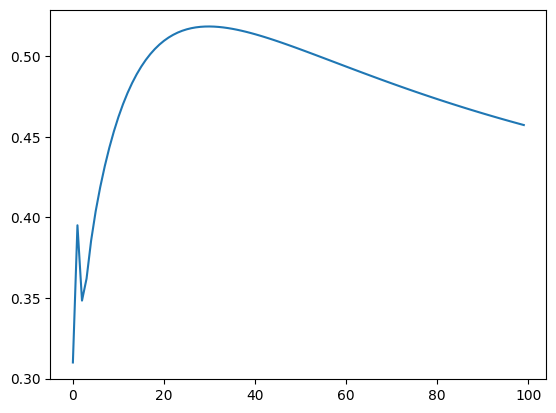

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [2]:
res = complete_tests.complete_tests2(
            'BIOMD0000000030.xml',
            'BIOMD0000000030_reaction1_100x.xml',
            'description_reaction_0000001_altered',
            []
        )

In [3]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  M expected result:  increased
confidence interval:  [0.4627820864068508, 0.4663142401789028]
Specie:  MpY expected result:  increased
confidence interval:  [0.5974459104093093, 0.6007125759404006]
Specie:  MpT expected result:  increased
confidence interval:  [0.47380057336043485, 0.47789491808440204]
Specie:  Mpp expected result:  decreased
confidence interval:  [0.37550033315093423, 0.37888289235294814]
Specie:  MAPKK expected result:  decreased
confidence interval:  [0.36022580221502815, 0.3613838324714547]
Specie:  MKP expected result:  increased
confidence interval:  [0.561111668029948, 0.5634992060582916]
Specie:  MpY_MAPKK expected result:  decreased
confidence interval:  [0.4889264580982551, 0.48992136842545075]
Specie:  MpT_MAPKK expected result:  decreased
confidence interval:  [0.460648410136192, 0.46164955192479223]
Specie:  M_MAPKK_Y expected result:  increased
confidence interval:  [0.5533358333407504, 0.5547012478906131]
Specie:  M_MAPKK_T expected result:  incr

In [4]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  18 correct experiments:  14 ratio:  0.7777777777777778


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

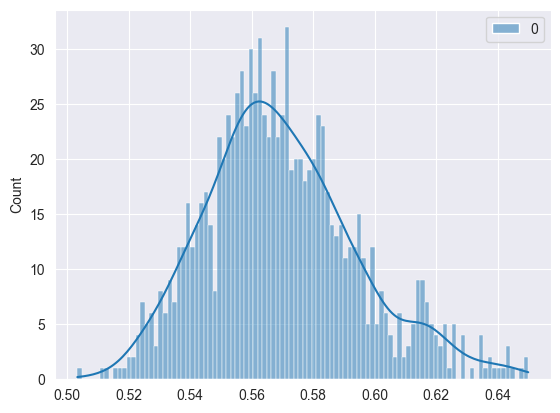

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)